## Carregamento dos dados

In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

X_ = torch.load('../data/processed/X_.pt')
y_ = torch.load('../data/processed/y_.pt')

real_set = TensorDataset(X_, y_)

X_0 = torch.load('../data/processed/X_0.pt')
X_1 = torch.load('../data/processed/X_1.pt')
X_2 = torch.load('../data/processed/X_2.pt')
X_3 = torch.load('../data/processed/X_3.pt')

X_0 = torch.from_numpy(np.expand_dims(X_0, axis=1))
X_1 = torch.from_numpy(np.expand_dims(X_1, axis=1))
X_2 = torch.from_numpy(np.expand_dims(X_2, axis=1))
X_3 = torch.from_numpy(np.expand_dims(X_3, axis=1))

gen_set_0 = TensorDataset(X_0, torch.as_tensor(np.full(1296, 0)))
gen_set_1 = TensorDataset(X_1, torch.as_tensor(np.full(1296, 1)))
gen_set_2 = TensorDataset(X_2, torch.as_tensor(np.full(1296, 2)))
gen_set_3 = TensorDataset(X_3, torch.as_tensor(np.full(1296, 3)))

print(X_0.shape)
print(X_1.shape)
print(X_2.shape)
print(X_3.shape)
print(X_.shape)
print(y_.shape)

/home/matias/Mestrado/venv_BCI/venv_BCI/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([1296, 1, 22, 1125])
torch.Size([5184, 22, 1125])
torch.Size([5184])


In [2]:
from torch.utils.data import random_split

gen_set_0_tr, gen_set_0_vl = random_split(gen_set_0, [648, 648])
gen_set_1_tr, gen_set_1_vl = random_split(gen_set_1, [648, 648])
gen_set_2_tr, gen_set_2_vl = random_split(gen_set_2, [648, 648])
gen_set_3_tr, gen_set_3_vl = random_split(gen_set_3, [648, 648])

In [3]:
gen_loader_0_tr = DataLoader(dataset=gen_set_0_tr, batch_size=648, shuffle=True)
gen_loader_0_vl = DataLoader(dataset=gen_set_0_vl, batch_size=648, shuffle=True)
gen_loader_1_tr = DataLoader(dataset=gen_set_1_tr, batch_size=648, shuffle=True)
gen_loader_1_vl = DataLoader(dataset=gen_set_1_vl, batch_size=648, shuffle=True)
gen_loader_2_tr = DataLoader(dataset=gen_set_2_tr, batch_size=648, shuffle=True)
gen_loader_2_vl = DataLoader(dataset=gen_set_2_vl, batch_size=648, shuffle=True)
gen_loader_3_tr = DataLoader(dataset=gen_set_3_tr, batch_size=648, shuffle=True)
gen_loader_3_vl = DataLoader(dataset=gen_set_3_vl, batch_size=648, shuffle=True)

## Definição do modelo do VAE

In [4]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
class CNN_VAE(nn.Module):
    def __init__(self):
        super(CNN_VAE, self).__init__()
 
        self.enc1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=4, stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2, stride=2, padding=0)
        
        self.fc1 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, 4)
        self.fc_log_var = nn.Linear(128, 4)
        self.fc2 = nn.Linear(4, 64)
        
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=(1, 140), stride=2, padding=0)
        self.dec2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4, 4), stride=2, padding=0)
        self.dec3 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(4, 1), stride=2, padding=0)
        self.dec4 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(4, 1), stride=2, padding=0)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        sample = mu + (eps * std)
        return sample
 
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        hidden = self.fc1(x)
        
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        
        z = self.reparameterize(mu, log_var)
        z = self.fc2(z)
        z = z.view(-1, 64, 1, 1)

        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction, mu, log_var

In [6]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
def train(model, dataloader, dataset, device, optimizer, criterion):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
        counter += 1
        data = data[0]
        data = data.to(device)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss / counter 
    return train_loss

In [8]:
def validate(model, dataloader, dataset, device, criterion):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(dataset)/dataloader.batch_size)):
            counter += 1
            data= data[0]
            data = data.to(device)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()

            if i == int(len(dataset)/dataloader.batch_size) - 1:
                fake = reconstruction
    val_loss = running_loss / counter
    return val_loss, fake

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_VAE().to(device)

In [10]:
from torchsummary import summary
summary(model, (1, 22, 1125))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 11, 562]             136
            Conv2d-2           [-1, 16, 5, 281]           2,064
            Conv2d-3           [-1, 32, 2, 140]           8,224
            Conv2d-4            [-1, 64, 1, 70]           8,256
            Linear-5                  [-1, 128]           8,320
            Linear-6                    [-1, 4]             516
            Linear-7                    [-1, 4]             516
            Linear-8                   [-1, 64]             320
   ConvTranspose2d-9           [-1, 64, 1, 140]         573,504
  ConvTranspose2d-10           [-1, 32, 4, 282]          32,800
  ConvTranspose2d-11          [-1, 16, 10, 563]           2,064
  ConvTranspose2d-12          [-1, 1, 22, 1125]              65
Total params: 636,785
Trainable params: 636,785
Non-trainable params: 0
-------------------------------

In [11]:
lr = 0.001
epochs = 100
batch_size = 648
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [12]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, gen_loader_0_tr, gen_set_0_tr, device, optimizer, criterion
    )
    valid_epoch_loss, fake = validate(
        model, gen_loader_0_vl, gen_set_0_tr, device, criterion
    )
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
print('TRAINING COMPLETE')

Epoch 1 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.45it/s]


Train Loss: 12293005.0000
Val Loss: 12271684.0000
Epoch 2 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.62it/s]


Train Loss: 12271589.0000
Val Loss: 12250443.0000
Epoch 3 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


Train Loss: 12250343.0000
Val Loss: 12228719.0000
Epoch 4 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.66it/s]


Train Loss: 12228462.0000
Val Loss: 12206548.0000
Epoch 5 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


Train Loss: 12206223.0000
Val Loss: 12182846.0000
Epoch 6 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: 12182412.0000
Val Loss: 12156331.0000
Epoch 7 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]


Train Loss: 12156307.0000
Val Loss: 12127073.0000
Epoch 8 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: 12126135.0000
Val Loss: 12094207.0000
Epoch 9 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: 12093766.0000
Val Loss: 12059373.0000
Epoch 10 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.70it/s]


Train Loss: 12057841.0000
Val Loss: 12016940.0000
Epoch 11 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train Loss: 12016595.0000
Val Loss: 11967601.0000
Epoch 12 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train Loss: 11966026.0000
Val Loss: 11902476.0000
Epoch 13 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


Train Loss: 11902352.0000
Val Loss: 11809644.0000
Epoch 14 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train Loss: 11814955.0000
Val Loss: 11680422.0000
Epoch 15 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.66it/s]


Train Loss: 11680156.0000
Val Loss: 11481965.0000
Epoch 16 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: 11482315.0000
Val Loss: 11199585.0000
Epoch 17 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: 11208886.0000
Val Loss: 10868327.0000
Epoch 18 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  8.90it/s]


Train Loss: 10902455.0000
Val Loss: 10640072.0000
Epoch 19 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: 10640307.0000
Val Loss: 10220826.0000
Epoch 20 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: 10242346.0000
Val Loss: 9906982.0000
Epoch 21 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: 9909854.0000
Val Loss: 9645350.0000
Epoch 22 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: 9655793.0000
Val Loss: 9412641.0000
Epoch 23 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 9417317.0000
Val Loss: 9246453.0000
Epoch 24 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 9244345.0000
Val Loss: 9132615.0000
Epoch 25 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train Loss: 9130652.0000
Val Loss: 9054354.0000
Epoch 26 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.61it/s]


Train Loss: 9045662.0000
Val Loss: 8992975.0000
Epoch 27 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: 8973250.0000
Val Loss: 8932545.0000
Epoch 28 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: 8892911.0000
Val Loss: 8857033.0000
Epoch 29 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: 8792957.0000
Val Loss: 8764258.0000
Epoch 30 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: 8669866.0000
Val Loss: 8654627.0000
Epoch 31 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: 8529827.0000
Val Loss: 8542598.0000
Epoch 32 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: 8379226.0000
Val Loss: 8425779.0000
Epoch 33 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: 8234599.5000
Val Loss: 8320213.5000
Epoch 34 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: 8092616.5000
Val Loss: 8210204.0000
Epoch 35 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: 7944619.5000
Val Loss: 8085330.0000
Epoch 36 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: 7768861.5000
Val Loss: 7915306.5000
Epoch 37 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: 7531863.5000
Val Loss: 7680072.5000
Epoch 38 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: 7200145.5000
Val Loss: 7374670.0000
Epoch 39 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: 6753493.0000
Val Loss: 6992087.0000
Epoch 40 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: 6192872.5000
Val Loss: 6571282.5000
Epoch 41 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: 5546852.0000
Val Loss: 6143541.0000
Epoch 42 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 4884779.0000
Val Loss: 5780658.5000
Epoch 43 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: 4278507.0000
Val Loss: 5473563.5000
Epoch 44 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: 3715937.0000
Val Loss: 5213189.0000
Epoch 45 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: 3183284.2500
Val Loss: 4980081.5000
Epoch 46 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: 2601538.2500
Val Loss: 4705366.5000
Epoch 47 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: 1953160.7500
Val Loss: 4311891.5000
Epoch 48 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: 1156867.3750
Val Loss: 3885315.0000
Epoch 49 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 450602.1250
Val Loss: 3553641.7500
Epoch 50 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: 21715.4375
Val Loss: 3289091.2500
Epoch 51 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -226584.5312
Val Loss: 3097217.2500
Epoch 52 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -415522.7500
Val Loss: 2899583.2500
Epoch 53 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -651799.7500
Val Loss: 2684667.7500
Epoch 54 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -954162.0000
Val Loss: 2446497.0000
Epoch 55 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: -1298145.1250
Val Loss: 2222739.7500
Epoch 56 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: -1671291.2500
Val Loss: 1947990.5000
Epoch 57 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -2108561.0000
Val Loss: 1693113.5000
Epoch 58 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -2605394.0000
Val Loss: 1472016.7500
Epoch 59 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -3055109.0000
Val Loss: 1279491.5000
Epoch 60 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -3345351.5000
Val Loss: 1113733.5000
Epoch 61 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -3608227.0000
Val Loss: 948480.8125
Epoch 62 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -3870621.5000
Val Loss: 805144.1250
Epoch 63 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -4086926.2500
Val Loss: 658900.6250
Epoch 64 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -4268077.0000
Val Loss: 554953.5000
Epoch 65 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -4410385.0000
Val Loss: 464547.3438
Epoch 66 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -4540229.0000
Val Loss: 327624.9062
Epoch 67 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -4731170.5000
Val Loss: 116421.2344
Epoch 68 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -5044373.0000
Val Loss: -165691.4844
Epoch 69 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]


Train Loss: -5430632.0000
Val Loss: -467441.1875
Epoch 70 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -5911820.0000
Val Loss: -756570.0000
Epoch 71 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -6355357.5000
Val Loss: -996528.7500
Epoch 72 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -6642651.5000
Val Loss: -1066522.5000
Epoch 73 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -6786828.5000
Val Loss: -1098736.7500
Epoch 74 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -6787021.0000
Val Loss: -1167566.2500
Epoch 75 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -6817136.0000
Val Loss: -1226312.2500
Epoch 76 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -6877210.0000
Val Loss: -1443141.8750
Epoch 77 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -7187286.0000
Val Loss: -1615508.3750
Epoch 78 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -7421278.5000
Val Loss: -1841409.8750
Epoch 79 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: -7825318.0000
Val Loss: -2023583.5000
Epoch 80 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -8087571.5000
Val Loss: -2047878.7500
Epoch 81 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8126875.5000
Val Loss: -2121058.5000
Epoch 82 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -8134406.0000
Val Loss: -2130084.0000
Epoch 83 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -8221462.0000
Val Loss: -2229611.2500
Epoch 84 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -8384516.0000
Val Loss: -2373011.2500
Epoch 85 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8528000.0000
Val Loss: -2435997.7500
Epoch 86 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -8626717.0000
Val Loss: -2514799.7500
Epoch 87 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -8728882.0000
Val Loss: -2649537.0000
Epoch 88 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -9003785.0000
Val Loss: -2797013.5000
Epoch 89 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -9155250.0000
Val Loss: -2813518.0000
Epoch 90 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -9171862.0000
Val Loss: -2816034.5000
Epoch 91 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.24it/s]


Train Loss: -9214514.0000
Val Loss: -2892493.0000
Epoch 92 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -9322546.0000
Val Loss: -3046394.5000
Epoch 93 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -9498312.0000
Val Loss: -3218258.0000
Epoch 94 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -9819033.0000
Val Loss: -3288503.7500
Epoch 95 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -9956445.0000
Val Loss: -3370883.7500
Epoch 96 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -9932796.0000
Val Loss: -3365491.0000
Epoch 97 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -9986445.0000
Val Loss: -3465408.0000
Epoch 98 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Train Loss: -10065405.0000
Val Loss: -3599567.5000
Epoch 99 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Train Loss: -10308951.0000
Val Loss: -3650924.0000
Epoch 100 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]

Train Loss: -10329735.0000
Val Loss: -3672441.5000
TRAINING COMPLETE


In [13]:
print(fake.shape)

torch.Size([648, 1, 22, 1125])


In [14]:
size=(22, 1125)
fake_0 = fake.detach().cpu().view(-1, *size)
print(fake_0.shape)

torch.Size([648, 22, 1125])


In [15]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [16]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, gen_loader_1_tr, gen_set_1_tr, device, optimizer, criterion
    )
    valid_epoch_loss, fake = validate(
        model, gen_loader_1_vl, gen_set_1_vl, device, criterion
    )
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
print('TRAINING COMPLETE')

Epoch 1 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.55it/s]


Train Loss: 1126154.2500
Val Loss: -298355.6875
Epoch 2 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: 989406.2500
Val Loss: -179770.2969
Epoch 3 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: 1033419.0625
Val Loss: 64432.2500
Epoch 4 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: 1128014.6250
Val Loss: 474050.1875
Epoch 5 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: 1385810.3750
Val Loss: 908082.5625
Epoch 6 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.58it/s]


Train Loss: 1689489.7500
Val Loss: 1141286.2500
Epoch 7 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 1781590.1250
Val Loss: 988312.8125
Epoch 8 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: 1570734.7500
Val Loss: 506684.4688
Epoch 9 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: 971128.1875
Val Loss: -118689.1875
Epoch 10 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: 229913.2969
Val Loss: -566915.7500
Epoch 11 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: -493758.1562
Val Loss: -869620.2500
Epoch 12 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


Train Loss: -843710.0625
Val Loss: -895032.6250
Epoch 13 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -1051624.5000
Val Loss: -890576.8125
Epoch 14 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -1249479.3750
Val Loss: -859794.5000
Epoch 15 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -1317568.5000
Val Loss: -765084.5625
Epoch 16 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -1369857.0000
Val Loss: -714517.0625
Epoch 17 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.14it/s]


Train Loss: -1451253.7500
Val Loss: -733816.6875
Epoch 18 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.27it/s]


Train Loss: -1486287.6250
Val Loss: -732498.8750
Epoch 19 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -1683058.3750
Val Loss: -805737.1250
Epoch 20 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -1778255.2500
Val Loss: -918550.2500
Epoch 21 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -2036694.7500
Val Loss: -1082962.8750
Epoch 22 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -2346807.5000
Val Loss: -1169698.2500
Epoch 23 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -2592225.2500
Val Loss: -1211891.2500
Epoch 24 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -2799915.0000
Val Loss: -1249334.2500
Epoch 25 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -2839793.0000
Val Loss: -1243862.0000
Epoch 26 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: -2942701.2500
Val Loss: -1231597.5000
Epoch 27 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -2957106.7500
Val Loss: -1250527.1250
Epoch 28 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -3070083.7500
Val Loss: -1277987.0000
Epoch 29 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: -3187272.0000
Val Loss: -1389021.0000
Epoch 30 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -3390268.0000
Val Loss: -1464560.7500
Epoch 31 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.60it/s]


Train Loss: -3602051.5000
Val Loss: -1626049.5000
Epoch 32 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -3858107.7500
Val Loss: -1686420.0000
Epoch 33 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -3987585.7500
Val Loss: -1795397.3750
Epoch 34 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -4197931.0000
Val Loss: -1773048.7500
Epoch 35 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: -4245082.0000
Val Loss: -1800898.1250
Epoch 36 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -4252035.0000
Val Loss: -1813471.1250
Epoch 37 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -4312649.5000
Val Loss: -1849880.0000
Epoch 38 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -4329358.0000
Val Loss: -1906985.3750
Epoch 39 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -4551335.0000
Val Loss: -2105078.5000
Epoch 40 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -4861873.0000
Val Loss: -2145646.2500
Epoch 41 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -4935521.0000
Val Loss: -2126594.7500
Epoch 42 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -4950906.5000
Val Loss: -2136515.7500
Epoch 43 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -4965754.0000
Val Loss: -2123990.5000
Epoch 44 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -5086824.5000
Val Loss: -2218376.2500
Epoch 45 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -5231226.0000
Val Loss: -2271610.7500
Epoch 46 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -5377470.0000
Val Loss: -2183545.2500
Epoch 47 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -5329262.5000
Val Loss: -2290274.2500
Epoch 48 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: -5437138.0000
Val Loss: -2358003.2500
Epoch 49 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -5721711.0000
Val Loss: -2459308.0000
Epoch 50 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.14it/s]


Train Loss: -5821632.0000
Val Loss: -2437398.5000
Epoch 51 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -5794573.0000
Val Loss: -2348275.5000
Epoch 52 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.55it/s]


Train Loss: -5715698.5000
Val Loss: -2408149.7500
Epoch 53 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -5830215.5000
Val Loss: -2436480.0000
Epoch 54 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -5960959.5000
Val Loss: -2427240.2500
Epoch 55 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -5926827.0000
Val Loss: -2504913.5000
Epoch 56 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -6063359.5000
Val Loss: -2581614.2500
Epoch 57 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: -6189797.0000
Val Loss: -2523240.7500
Epoch 58 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6197886.5000
Val Loss: -2495526.5000
Epoch 59 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.57it/s]


Train Loss: -6124418.5000
Val Loss: -2561848.5000
Epoch 60 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -6286480.5000
Val Loss: -2666700.7500
Epoch 61 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -6455271.0000
Val Loss: -2638389.0000
Epoch 62 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6412079.0000
Val Loss: -2572374.5000
Epoch 63 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -6388975.0000
Val Loss: -2635891.7500
Epoch 64 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -6459954.0000
Val Loss: -2647496.0000
Epoch 65 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6582314.5000
Val Loss: -2644172.2500
Epoch 66 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -6516081.0000
Val Loss: -2713744.2500
Epoch 67 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6651427.5000
Val Loss: -2787539.2500
Epoch 68 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6799289.0000
Val Loss: -2830908.5000
Epoch 69 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -6850764.5000
Val Loss: -2785398.0000
Epoch 70 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6796266.5000
Val Loss: -2792448.0000
Epoch 71 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -6889058.0000
Val Loss: -2916422.7500
Epoch 72 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -7062895.0000
Val Loss: -2863658.5000
Epoch 73 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -7068767.0000
Val Loss: -2834887.2500
Epoch 74 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -7036419.5000
Val Loss: -2893838.5000
Epoch 75 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -7144388.5000
Val Loss: -2951048.2500
Epoch 76 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -7214999.0000
Val Loss: -2982969.7500
Epoch 77 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -7376457.5000
Val Loss: -3041004.0000
Epoch 78 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -7448456.0000
Val Loss: -2976051.5000
Epoch 79 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -7321190.0000
Val Loss: -3018719.2500
Epoch 80 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -7474367.5000
Val Loss: -3071293.2500
Epoch 81 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -7458553.5000
Val Loss: -3089876.0000
Epoch 82 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -7576472.0000
Val Loss: -3071790.2500
Epoch 83 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -7581820.5000
Val Loss: -3079193.0000
Epoch 84 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.36it/s]


Train Loss: -7618273.5000
Val Loss: -3199302.2500
Epoch 85 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -7772505.0000
Val Loss: -3116015.2500
Epoch 86 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -7680784.5000
Val Loss: -3212808.5000
Epoch 87 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.59it/s]


Train Loss: -7878000.5000
Val Loss: -3216541.7500
Epoch 88 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -7934999.0000
Val Loss: -3189894.5000
Epoch 89 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -7901784.0000
Val Loss: -3240680.5000
Epoch 90 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.25it/s]


Train Loss: -7955205.0000
Val Loss: -3269756.7500
Epoch 91 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -8095664.5000
Val Loss: -3257429.0000
Epoch 92 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -8066467.5000
Val Loss: -3209741.5000
Epoch 93 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -8021447.5000
Val Loss: -3304128.5000
Epoch 94 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -8212587.0000
Val Loss: -3289686.7500
Epoch 95 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -8182047.0000
Val Loss: -3281338.7500
Epoch 96 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -8215349.0000
Val Loss: -3344358.7500
Epoch 97 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8330616.0000
Val Loss: -3363143.2500
Epoch 98 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8397278.0000
Val Loss: -3321010.7500
Epoch 99 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -8281251.0000
Val Loss: -3495283.2500
Epoch 100 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]

Train Loss: -8651802.0000
Val Loss: -3311798.5000
TRAINING COMPLETE


In [17]:
print(fake.shape)

torch.Size([648, 1, 22, 1125])


In [18]:
fake_1 = fake.detach().cpu().view(-1, *size)
print(fake_1.shape)

torch.Size([648, 22, 1125])


In [19]:
gc.collect()
torch.cuda.empty_cache()

In [20]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, gen_loader_2_tr, gen_set_2_tr, device, optimizer, criterion
    )
    valid_epoch_loss, fake = validate(
        model, gen_loader_2_vl, gen_set_2_vl, device, criterion
    )
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
print('TRAINING COMPLETE')

Epoch 1 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.34it/s]


Train Loss: -3313384.2500
Val Loss: -2784148.2500
Epoch 2 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -3136211.5000
Val Loss: -2314423.5000
Epoch 3 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.65it/s]


Train Loss: -2696270.5000
Val Loss: -1780418.0000
Epoch 4 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


Train Loss: -2255909.2500
Val Loss: -1646213.1250
Epoch 5 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -2186663.7500
Val Loss: -2076151.6250
Epoch 6 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -2740601.5000
Val Loss: -2813197.5000
Epoch 7 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -3746770.2500
Val Loss: -3547445.2500
Epoch 8 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -4689572.5000
Val Loss: -3900325.0000
Epoch 9 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: -5245379.5000
Val Loss: -3860778.5000
Epoch 10 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -5290278.0000
Val Loss: -3497183.5000
Epoch 11 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -5085909.0000
Val Loss: -3161229.5000
Epoch 12 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.49it/s]


Train Loss: -4890545.5000
Val Loss: -3135716.0000
Epoch 13 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -5105049.5000
Val Loss: -3341481.5000
Epoch 14 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -5272753.5000
Val Loss: -3658405.7500
Epoch 15 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -5919154.5000
Val Loss: -3891657.5000
Epoch 16 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -6256447.0000
Val Loss: -3787515.0000
Epoch 17 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.44it/s]


Train Loss: -6326050.5000
Val Loss: -3637043.2500
Epoch 18 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -6169176.5000
Val Loss: -3357381.2500
Epoch 19 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -6041629.0000
Val Loss: -3334567.5000
Epoch 20 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -6175875.0000
Val Loss: -3683225.2500
Epoch 21 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -6580533.5000
Val Loss: -3834300.7500
Epoch 22 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.53it/s]


Train Loss: -6927415.0000
Val Loss: -3775294.2500
Epoch 23 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.63it/s]


Train Loss: -6901051.5000
Val Loss: -3622792.5000
Epoch 24 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -6840505.5000
Val Loss: -3775365.7500
Epoch 25 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.62it/s]


Train Loss: -7120126.5000
Val Loss: -3741952.7500
Epoch 26 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -7244804.0000
Val Loss: -3668051.0000
Epoch 27 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -7194955.0000
Val Loss: -3641498.2500
Epoch 28 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -7337315.5000
Val Loss: -3688207.0000
Epoch 29 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -7313574.5000
Val Loss: -3856460.2500
Epoch 30 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -7637187.0000
Val Loss: -3742042.0000
Epoch 31 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -7674135.5000
Val Loss: -3490668.5000
Epoch 32 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -7417256.5000
Val Loss: -3490880.7500
Epoch 33 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -7568155.5000
Val Loss: -3731158.7500
Epoch 34 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.20it/s]


Train Loss: -7835322.0000
Val Loss: -3660743.2500
Epoch 35 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -7841953.5000
Val Loss: -3516794.0000
Epoch 36 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -7778195.5000
Val Loss: -3471136.5000
Epoch 37 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -7868516.5000
Val Loss: -3590644.2500
Epoch 38 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -8010346.5000
Val Loss: -3613775.5000
Epoch 39 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -8183625.0000
Val Loss: -3421033.5000
Epoch 40 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


Train Loss: -7958544.0000
Val Loss: -3750933.0000
Epoch 41 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8507457.0000
Val Loss: -3697807.2500
Epoch 42 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


Train Loss: -8437367.0000
Val Loss: -3486153.2500
Epoch 43 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -8096824.0000
Val Loss: -3677698.0000
Epoch 44 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.23it/s]


Train Loss: -8481395.0000
Val Loss: -3738986.5000
Epoch 45 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -8679789.0000
Val Loss: -3400277.2500
Epoch 46 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8229955.0000
Val Loss: -3735131.7500
Epoch 47 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8747363.0000
Val Loss: -3752007.7500
Epoch 48 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -8754082.0000
Val Loss: -3551626.0000
Epoch 49 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8602393.0000
Val Loss: -3658912.7500
Epoch 50 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.16it/s]


Train Loss: -8779543.0000
Val Loss: -3693528.5000
Epoch 51 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -8870904.0000
Val Loss: -3663454.5000
Epoch 52 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -8915566.0000
Val Loss: -3598851.2500
Epoch 53 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -8838546.0000
Val Loss: -3900335.7500
Epoch 54 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -9283700.0000
Val Loss: -3366829.7500
Epoch 55 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8593566.0000
Val Loss: -3885692.2500
Epoch 56 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -9424759.0000
Val Loss: -3681729.2500
Epoch 57 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.47it/s]


Train Loss: -9219298.0000
Val Loss: -3507613.0000
Epoch 58 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -8896929.0000
Val Loss: -4068726.2500
Epoch 59 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -9816563.0000
Val Loss: -3582525.5000
Epoch 60 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -9102826.0000
Val Loss: -3677523.0000
Epoch 61 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.24it/s]


Train Loss: -9305752.0000
Val Loss: -4025392.0000
Epoch 62 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -9794195.0000
Val Loss: -3443052.5000
Epoch 63 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -8935679.0000
Val Loss: -4103593.2500
Epoch 64 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10013969.0000
Val Loss: -3743073.5000
Epoch 65 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -9491541.0000
Val Loss: -3698272.0000
Epoch 66 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -9484107.0000
Val Loss: -4021737.0000
Epoch 67 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -10045429.0000
Val Loss: -3644578.2500
Epoch 68 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -9482252.0000
Val Loss: -4006152.2500
Epoch 69 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.51it/s]


Train Loss: -9937150.0000
Val Loss: -3957459.0000
Epoch 70 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10036771.0000
Val Loss: -3496981.5000
Epoch 71 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -9368455.0000
Val Loss: -4437508.5000
Epoch 72 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -10812221.0000
Val Loss: -3522849.0000
Epoch 73 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -9575826.0000
Val Loss: -3940903.5000
Epoch 74 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -10149420.0000
Val Loss: -4012008.7500
Epoch 75 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10314410.0000
Val Loss: -3691966.2500
Epoch 76 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.21it/s]


Train Loss: -9779447.0000
Val Loss: -4225059.5000
Epoch 77 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10623438.0000
Val Loss: -3911709.2500
Epoch 78 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -10175820.0000
Val Loss: -3850505.7500
Epoch 79 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -10185423.0000
Val Loss: -4311898.5000
Epoch 80 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.54it/s]


Train Loss: -10846621.0000
Val Loss: -3674470.0000
Epoch 81 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]


Train Loss: -10008378.0000
Val Loss: -4214333.5000
Epoch 82 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -10848623.0000
Val Loss: -3871766.7500
Epoch 83 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -10417690.0000
Val Loss: -4035612.5000
Epoch 84 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -10616175.0000
Val Loss: -4073794.0000
Epoch 85 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -10687378.0000
Val Loss: -3969520.7500
Epoch 86 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -10641578.0000
Val Loss: -4000033.0000
Epoch 87 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -10716133.0000
Val Loss: -3978553.0000
Epoch 88 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -10710823.0000
Val Loss: -4101947.0000
Epoch 89 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -10946086.0000
Val Loss: -3922528.2500
Epoch 90 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -10786915.0000
Val Loss: -4224927.5000
Epoch 91 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -11260879.0000
Val Loss: -3473007.0000
Epoch 92 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -10052004.0000
Val Loss: -5380746.5000
Epoch 93 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -13028560.0000
Val Loss: -3816426.5000
Epoch 94 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]


Train Loss: -10771016.0000
Val Loss: -3493964.5000
Epoch 95 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -10193172.0000
Val Loss: -4753734.0000
Epoch 96 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -12097696.0000
Val Loss: -3946185.5000
Epoch 97 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.36it/s]


Train Loss: -10989368.0000
Val Loss: -4030984.2500
Epoch 98 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -11068551.0000
Val Loss: -4569233.0000
Epoch 99 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


Train Loss: -11792677.0000
Val Loss: -3890125.5000
Epoch 100 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]

Train Loss: -10786448.0000
Val Loss: -4248124.5000
TRAINING COMPLETE


In [21]:
print(fake.shape)

torch.Size([648, 1, 22, 1125])


In [22]:
fake_2 = fake.detach().cpu().view(-1, *size)
print(fake_2.shape)

torch.Size([648, 22, 1125])


In [23]:
gc.collect()
torch.cuda.empty_cache()

In [24]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, gen_loader_3_tr, gen_set_3_tr, device, optimizer, criterion
    )
    valid_epoch_loss, fake = validate(
        model, gen_loader_3_vl, gen_set_3_vl, device, criterion
    )
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {valid_epoch_loss:.4f}")
print('TRAINING COMPLETE')

Epoch 1 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.50it/s]


Train Loss: -3917244.5000
Val Loss: -2403461.0000
Epoch 2 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


Train Loss: -3559268.5000
Val Loss: -1497045.1250
Epoch 3 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -2656020.0000
Val Loss: -667794.7500
Epoch 4 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -1899483.5000
Val Loss: -650605.7500
Epoch 5 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -2098149.2500
Val Loss: -1478419.0000
Epoch 6 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -3144683.0000
Val Loss: -2606587.2500
Epoch 7 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -4911057.5000
Val Loss: -3410397.2500
Epoch 8 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.22it/s]


Train Loss: -6373403.5000
Val Loss: -3817943.2500
Epoch 9 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -7265239.5000
Val Loss: -3855330.0000
Epoch 10 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -7752310.0000
Val Loss: -3807532.0000
Epoch 11 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -7741915.0000
Val Loss: -3478479.5000
Epoch 12 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -7338211.0000
Val Loss: -3097128.0000
Epoch 13 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -6881807.0000
Val Loss: -2825953.2500
Epoch 14 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]


Train Loss: -6601038.0000
Val Loss: -2775226.7500
Epoch 15 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -6731115.5000
Val Loss: -3034381.2500
Epoch 16 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -7300615.5000
Val Loss: -3299106.2500
Epoch 17 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -8211508.5000
Val Loss: -3386392.0000
Epoch 18 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -8594136.0000
Val Loss: -3109744.0000
Epoch 19 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.34it/s]


Train Loss: -8435956.0000
Val Loss: -2845459.0000
Epoch 20 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.29it/s]


Train Loss: -7906142.5000
Val Loss: -2640085.0000
Epoch 21 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.52it/s]


Train Loss: -7749075.5000
Val Loss: -2657682.5000
Epoch 22 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -7915329.5000
Val Loss: -2778403.2500
Epoch 23 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8279901.5000
Val Loss: -2810136.2500
Epoch 24 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -8628692.0000
Val Loss: -2676067.5000
Epoch 25 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.36it/s]


Train Loss: -8440424.0000
Val Loss: -2574896.2500
Epoch 26 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -8460874.0000
Val Loss: -2543478.7500
Epoch 27 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -8531814.0000
Val Loss: -2585142.2500
Epoch 28 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -8768516.0000
Val Loss: -2716356.2500
Epoch 29 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -8842709.0000
Val Loss: -2572794.7500
Epoch 30 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -8672212.0000
Val Loss: -2517343.7500
Epoch 31 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -8766938.0000
Val Loss: -2735600.7500
Epoch 32 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -9235128.0000
Val Loss: -2689457.0000
Epoch 33 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.33it/s]


Train Loss: -9492359.0000
Val Loss: -2746887.2500
Epoch 34 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -9555454.0000
Val Loss: -2804985.5000
Epoch 35 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -9623041.0000
Val Loss: -2796424.5000
Epoch 36 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -9678876.0000
Val Loss: -2775008.0000
Epoch 37 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -9838206.0000
Val Loss: -2877070.2500
Epoch 38 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -9940876.0000
Val Loss: -2790758.7500
Epoch 39 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -10004731.0000
Val Loss: -2806338.0000
Epoch 40 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


Train Loss: -10239894.0000
Val Loss: -2771633.0000
Epoch 41 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.28it/s]


Train Loss: -10318945.0000
Val Loss: -2756417.2500
Epoch 42 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10193919.0000
Val Loss: -2695257.7500
Epoch 43 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -10325592.0000
Val Loss: -2705518.0000
Epoch 44 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.36it/s]


Train Loss: -10464733.0000
Val Loss: -2742985.0000
Epoch 45 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -10726932.0000
Val Loss: -2678395.5000
Epoch 46 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -10713102.0000
Val Loss: -2688161.7500
Epoch 47 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -10852637.0000
Val Loss: -2688835.7500
Epoch 48 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -10941789.0000
Val Loss: -2762525.2500
Epoch 49 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -11197046.0000
Val Loss: -2712803.5000
Epoch 50 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  9.02it/s]


Train Loss: -11272273.0000
Val Loss: -2752667.7500
Epoch 51 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.40it/s]


Train Loss: -11381932.0000
Val Loss: -2730797.2500
Epoch 52 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -11587204.0000
Val Loss: -2711957.7500
Epoch 53 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -11651285.0000
Val Loss: -2603481.0000
Epoch 54 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -11634220.0000
Val Loss: -2670976.2500
Epoch 55 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.26it/s]


Train Loss: -12358198.0000
Val Loss: -2376961.0000
Epoch 56 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -11359191.0000
Val Loss: -3023617.5000
Epoch 57 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -14012296.0000
Val Loss: -1911990.7500
Epoch 58 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -10258175.0000
Val Loss: -2886909.7500
Epoch 59 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -14002801.0000
Val Loss: -2733570.7500
Epoch 60 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.47it/s]


Train Loss: -13443940.0000
Val Loss: -2064042.0000
Epoch 61 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.74it/s]


Train Loss: -11129694.0000
Val Loss: -2725408.2500
Epoch 62 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.58it/s]


Train Loss: -14178335.0000
Val Loss: -2575538.7500
Epoch 63 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Train Loss: -13675789.0000
Val Loss: -2060667.2500
Epoch 64 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.01it/s]


Train Loss: -11587796.0000
Val Loss: -2533172.5000
Epoch 65 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.56it/s]


Train Loss: -14732475.0000
Val Loss: -2366703.5000
Epoch 66 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.81it/s]


Train Loss: -14074026.0000
Val Loss: -2039533.2500
Epoch 67 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.03it/s]


Train Loss: -12211073.0000
Val Loss: -2385713.7500
Epoch 68 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.02it/s]


Train Loss: -15359646.0000
Val Loss: -2123290.0000
Epoch 69 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Train Loss: -14016105.0000
Val Loss: -1781573.5000
Epoch 70 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Train Loss: -12893950.0000
Val Loss: -2226032.0000
Epoch 71 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.16it/s]


Train Loss: -15944915.0000
Val Loss: -1927702.6250
Epoch 72 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.99it/s]


Train Loss: -14146389.0000
Val Loss: -1756327.8750
Epoch 73 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.05it/s]


Train Loss: -13556651.0000
Val Loss: -2181597.5000
Epoch 74 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.95it/s]


Train Loss: -16408606.0000
Val Loss: -1698765.5000
Epoch 75 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Train Loss: -14009728.0000
Val Loss: -1752190.2500
Epoch 76 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.10it/s]


Train Loss: -14385095.0000
Val Loss: -2164890.7500
Epoch 77 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.96it/s]


Train Loss: -16468186.0000
Val Loss: -1738031.0000
Epoch 78 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.32it/s]


Train Loss: -14336796.0000
Val Loss: -2003738.0000
Epoch 79 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.36it/s]


Train Loss: -15447796.0000
Val Loss: -2120722.7500
Epoch 80 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -16254353.0000
Val Loss: -1799553.2500
Epoch 81 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -14659861.0000
Val Loss: -2297117.7500
Epoch 82 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -17259092.0000
Val Loss: -1946425.5000
Epoch 83 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -15223198.0000
Val Loss: -2188591.7500
Epoch 84 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -16587144.0000
Val Loss: -2283542.7500
Epoch 85 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -16867806.0000
Val Loss: -2072700.0000
Epoch 86 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.42it/s]


Train Loss: -15517310.0000
Val Loss: -2553284.7500
Epoch 87 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.48it/s]


Train Loss: -18304098.0000
Val Loss: -2359802.2500
Epoch 88 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -15971722.0000
Val Loss: -2669181.2500
Epoch 89 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.35it/s]


Train Loss: -17821354.0000
Val Loss: -2629378.5000
Epoch 90 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.38it/s]


Train Loss: -17559968.0000
Val Loss: -2459710.0000
Epoch 91 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.46it/s]


Train Loss: -16421980.0000
Val Loss: -2828156.2500
Epoch 92 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.41it/s]


Train Loss: -18693276.0000
Val Loss: -2552748.7500
Epoch 93 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.45it/s]


Train Loss: -16893176.0000
Val Loss: -2890060.5000
Epoch 94 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.37it/s]


Train Loss: -18215680.0000
Val Loss: -2928685.2500
Epoch 95 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.50it/s]


Train Loss: -18637562.0000
Val Loss: -2642201.2500
Epoch 96 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]


Train Loss: -17104416.0000
Val Loss: -3006991.2500
Epoch 97 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.43it/s]


Train Loss: -19681186.0000
Val Loss: -2747605.5000
Epoch 98 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.31it/s]


Train Loss: -17334790.0000
Val Loss: -3119242.7500
Epoch 99 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.30it/s]


Train Loss: -19051354.0000
Val Loss: -3127870.2500
Epoch 100 of 100


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 14.39it/s]

Train Loss: -19041100.0000
Val Loss: -3009197.0000
TRAINING COMPLETE


In [25]:
print(fake.shape)

torch.Size([648, 1, 22, 1125])


In [26]:
fake_3 = fake.detach().cpu().view(-1, *size)
print(fake_3.shape)

torch.Size([648, 22, 1125])


In [27]:
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()

## Processamento dos dados sintéticos para classificação

In [28]:
fake = torch.cat((fake_0, fake_1, fake_2, fake_3), 0)
y_fake = torch.cat((torch.as_tensor(np.full(648, 0)), torch.as_tensor(np.full(648, 1)), torch.as_tensor(np.full(648, 2)), torch.as_tensor(np.full(648, 3))), 0)
print(fake.shape)
print(y_fake.shape)

torch.Size([2592, 22, 1125])
torch.Size([2592])


In [29]:
import numpy as np
from scipy import signal

window_size = 128
overlap = 64
fft_size = 128
sampling_rate = 250

spectrograms_spectrogram = []

for i in range(fake.shape[0]):
    f, t, spectrogram = signal.spectrogram(fake[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms_spectrogram.append(spectrogram)

spectrograms_spectrogram = np.array(spectrograms_spectrogram)

(2592, 22, 65, 16)


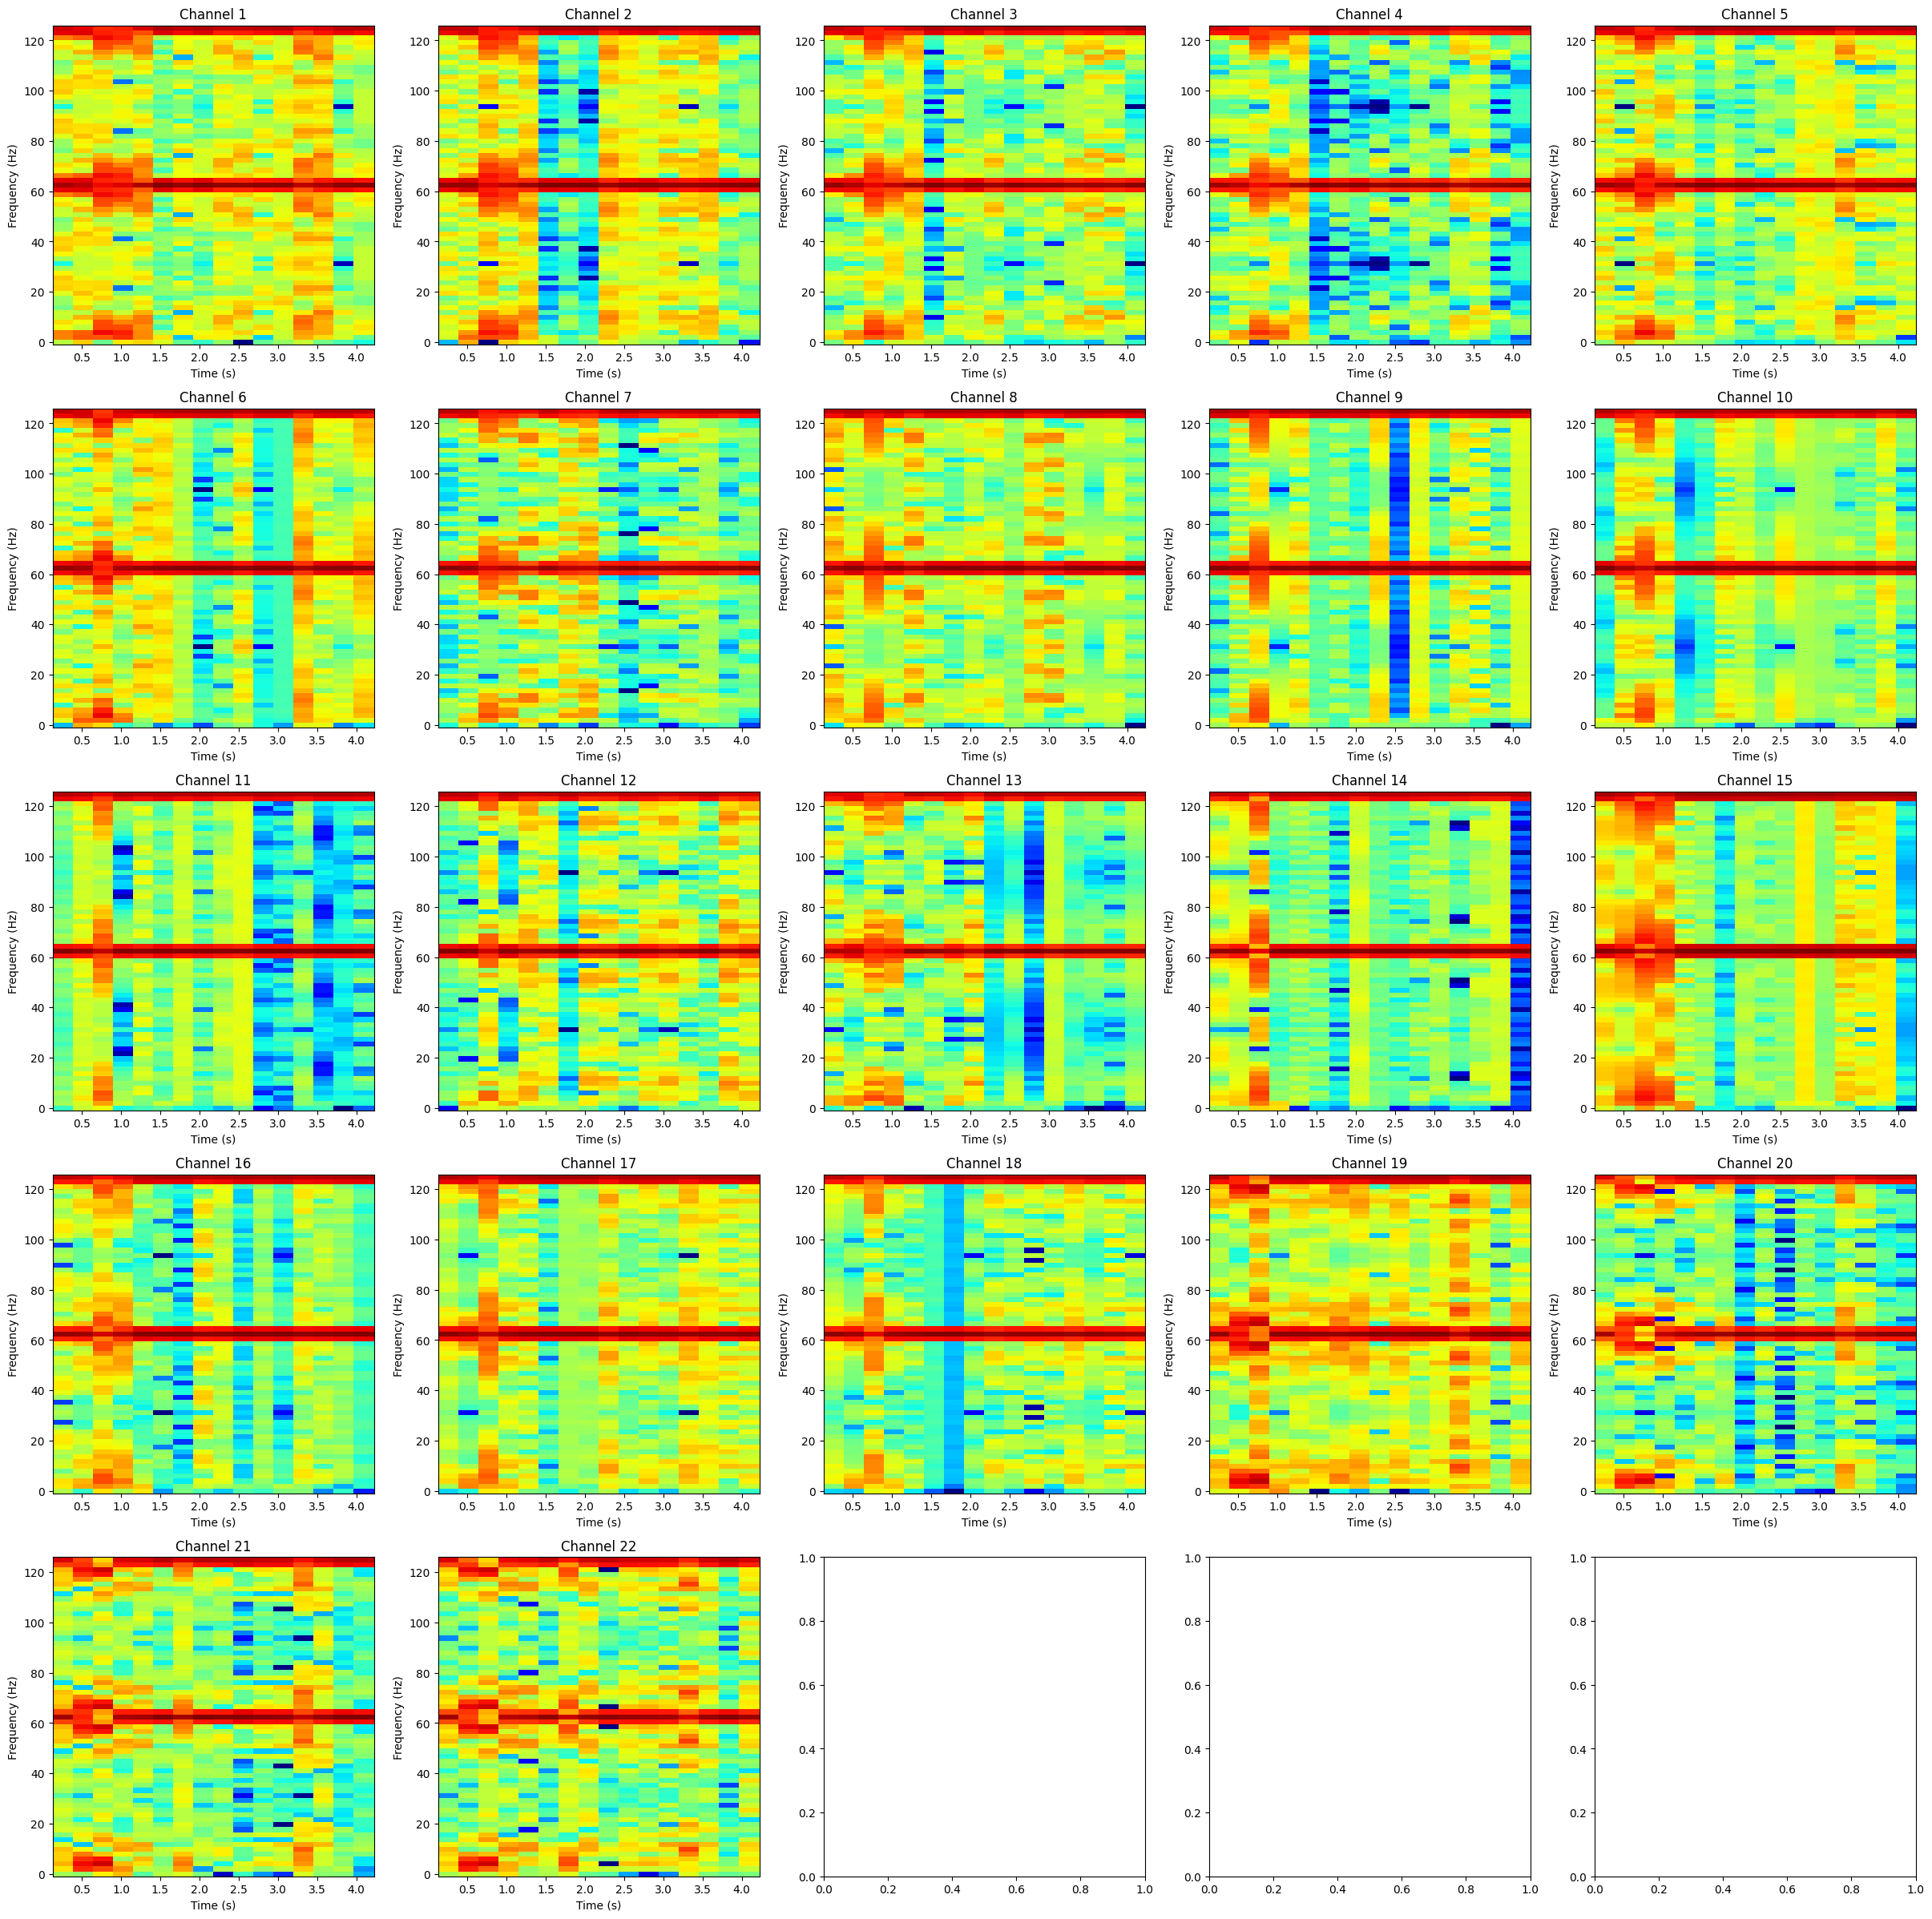

In [30]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(30, 30))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][i*5+j, :, :])), cmap='jet')
        axs[i,j].set_title('Channel ' + str(i*5+j+1))
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        if(i*5+j == 21):
            break
    if(i*5+j == 21):
        break

print(spectrograms_spectrogram.shape)
plt.show()

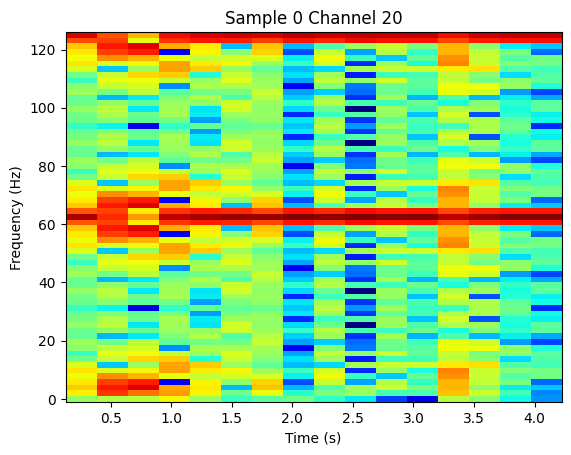

In [36]:
plt.pcolormesh(t, f, 20*np.log10(abs(spectrograms_spectrogram[0][19, :, :])), cmap='jet')
plt.title('Sample 0 Channel 20')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [31]:
fake_set = TensorDataset(fake, y_fake)

In [32]:
fake_fulltrainset, fake_evalset = random_split(fake_set, [1296, 1296])
fake_trainset, fake_testset = random_split(fake_fulltrainset, [864, 432])
real_fulltrainset, real_evalset = random_split(real_set, [2592, 2592])
real_trainset, real_testset = random_split(real_fulltrainset, [1728, 864])

## Definição do modelo do classificador

In [33]:
from braindecode.util import set_random_seeds
from braindecode.models import EEGNetv4

cuda = torch.cuda.is_available()
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = False

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
n_chans = 22
input_window_samples = 1125
F1, D = 4, 2
kernel_length = 64

model = EEGNetv4(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
    F1=8,
    D=2,
    F2=F1*D,
    kernel_length=kernel_length,
    drop_prob=0.5
)
model.to(device);

## Treinamento do classificador com dados reais

In [34]:
from skorch.helper import predefined_split
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

batch_size = 32
n_epochs = 50

real_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(real_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
real_clf.fit(real_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.3524        1.4201            0.3611        1.3501  0.0100  0.7633
      2            0.3929        1.3440            0.3241        1.3922  0.0100  0.6606
      3            0.4497        1.3094            0.3935        1.2806  0.0100  0.6520
      4            0.5179        1.2643            0.4329        1.2393  0.0099  0.6506
      5            0.5394        1.2485            0.4595        1.1917  0.0098  0.6528
      6            0.5006        1.2229            0.4502        1.2362  0.0097  0.6578
      7            0.5434        1.1970            0.4734        1.2147  0.0096  0.6609
      8            0.5440        1.1732            0.4734        1.1634  0.0095  0.6725
      9            0.5596        1.1464            0.4583        1.1697  0.0094  0.6778
     10            0.5544       

In [35]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 57.95%


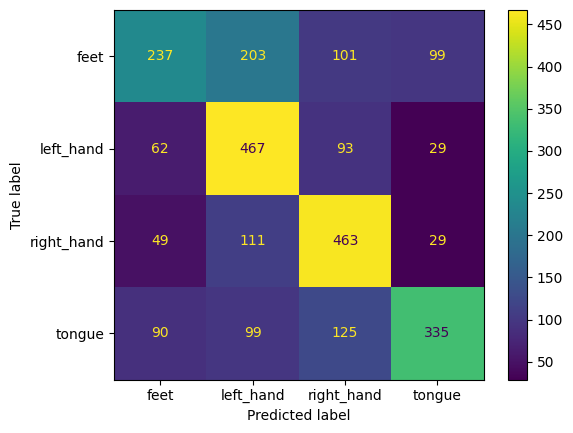

In [36]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

trtr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=trtr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [37]:
print(f"Mean Accuracy: {np.mean(real_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 24.15%


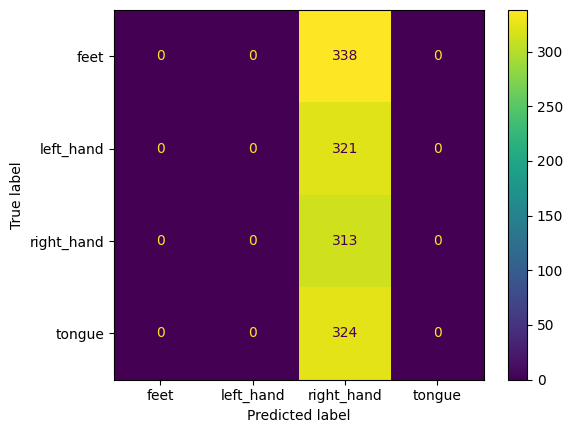

In [38]:
trts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=trts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Treinamento do classificador com dados sintéticos

In [39]:
fake_clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.Adam,
    train_split=predefined_split(fake_testset),
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
)
fake_clf.fit(fake_trainset, y=None, epochs=n_epochs);

  epoch    train_accuracy    train_loss    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  ----------------  ------------  ------  ------
      1            0.2650        0.1809            0.2454        1.5764  0.0100  0.3587
      2            0.2650        0.0058            0.2454        1.7913  0.0100  0.3285
      3            0.4954        0.0011            0.5023        1.7716  0.0100  0.3422
      4            0.2650        0.0012            0.2454        1.7968  0.0099  0.3380
      5            0.4630        0.0013            0.4699        1.7493  0.0098  0.3435
      6            0.4954        0.0010            0.5023        1.5696  0.0097  0.3369
      7            0.4954        0.0003            0.5023        1.5317  0.0096  0.3301
      8            0.4954        0.0005            0.5023        1.4668  0.0095  0.3326
      9            0.4954        0.0002            0.5023        1.3978  0.0094  0.3483
     10            0.4954       

In [40]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(real_evalset) == [y for X,y in real_evalset])*100:.2f}%")

Mean Accuracy: 25.04%


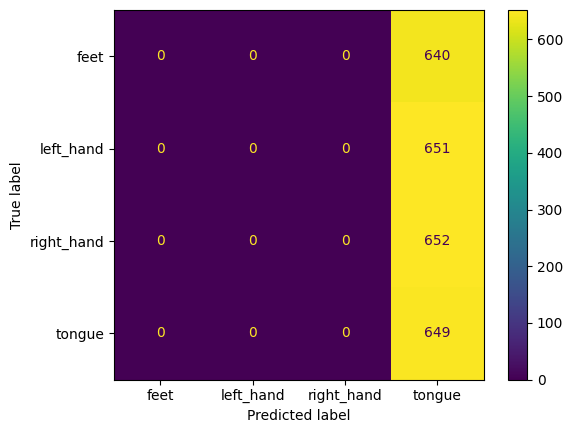

In [41]:
tstr = real_clf.predict(real_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in real_evalset],
    y_pred=tstr,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

In [42]:
print(f"Mean Accuracy: {np.mean(fake_clf.predict(fake_evalset) == [y for X,y in fake_evalset])*100:.2f}%")

Mean Accuracy: 100.00%


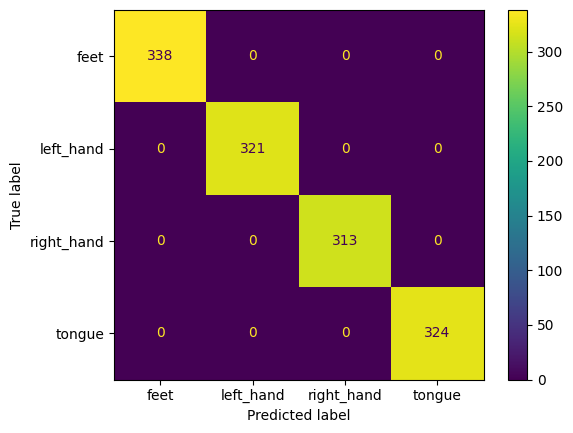

In [43]:
tsts = real_clf.predict(fake_evalset)

conf_matrix = confusion_matrix(
    y_true=[y for _,y in fake_evalset],
    y_pred=tsts,
    labels=list([0, 1, 2, 3]),
)

disp = ConfusionMatrixDisplay(
    confusion_matrix=conf_matrix, 
    display_labels=list(["feet", "left_hand", "right_hand", "tongue"])
)
disp.plot()
plt.show();

## Distância euclidiana entre os dados reais e sintéticos

In [48]:
size=(22, 1125)
real = X_[:2592].view(-1, *size)

In [49]:
torch.norm(real-fake, 2)

tensor(23613.5742)